# 03 - ML Pipeline

**LoanGuardian** — Training, evaluating, and comparing ML models for UAE synthetic loan dataset.

Algorithms:

- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

Metrics:

- Recall (primary)
- Precision
- F1-score
- Confusion matrix
- ROC-AUC


In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay


In [2]:
# 2. Load Preprocessed Data
X_train = pd.read_csv('../data/processed/X_train_res.csv')
y_train = pd.read_csv('../data/processed/y_train_res.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print('Training shape:', X_train.shape)
print('Test shape:', X_test.shape)


Training shape: (76380, 22)
Test shape: (10000, 22)


In [3]:
## 3. Helper Functions
# Function to evaluate model
def evaluate_model(model, X_test, y_test, plot_roc=True):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()
    
    if y_prob is not None and plot_roc:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f'ROC Curve - {model.__class__.__name__}')
        plt.show()


Best Params: {'C': 0.01, 'solver': 'liblinear'}
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9548
           1       0.72      1.00      0.84       452

    accuracy                           0.98     10000
   macro avg       0.86      0.99      0.91     10000
weighted avg       0.99      0.98      0.98     10000



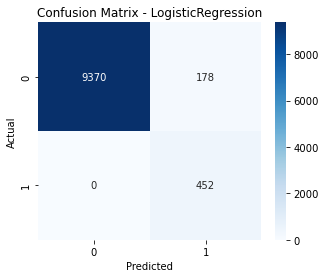

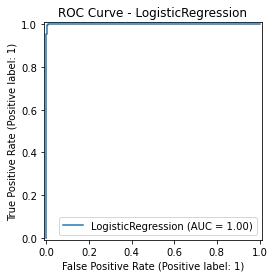

In [4]:
## 4. Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_params = {
    'C':[0.01,0.1,1,10],
    'solver':['liblinear','lbfgs']
}

lr_grid = GridSearchCV(lr, lr_params, scoring='recall', cv=5, n_jobs=-1)
lr_grid.fit(X_train, y_train)

print('Best Params:', lr_grid.best_params_)
evaluate_model(lr_grid.best_estimator_, X_test, y_test)


Best Params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9548
           1       1.00      1.00      1.00       452

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



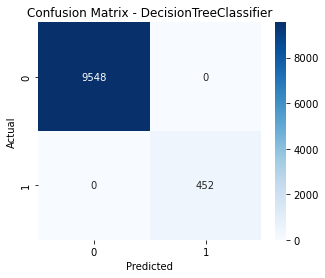

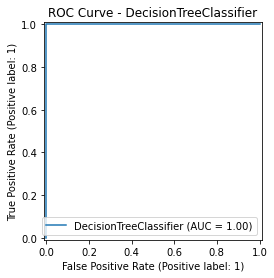

In [5]:
## 5. Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_params = {
    'max_depth':[3,5,7,10,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,5]
}

dt_grid = GridSearchCV(dt, dt_params, scoring='recall', cv=5, n_jobs=-1)
dt_grid.fit(X_train, y_train)

print('Best Params:', dt_grid.best_params_)
evaluate_model(dt_grid.best_estimator_, X_test, y_test)


Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9548
           1       1.00      1.00      1.00       452

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



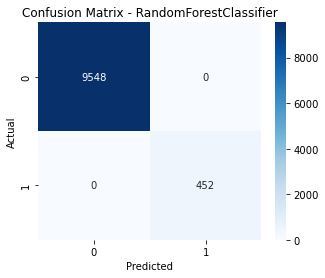

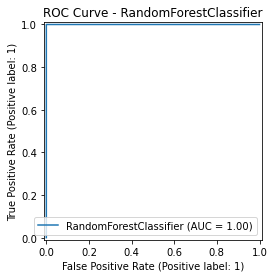

In [6]:
## 6. Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_params = {
    'n_estimators':[100,200],
    'max_depth':[5,10,15,None],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]
}

rf_grid = GridSearchCV(rf, rf_params, scoring='recall', cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print('Best Params:', rf_grid.best_params_)
evaluate_model(rf_grid.best_estimator_, X_test, y_test)


Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9548
           1       1.00      1.00      1.00       452

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



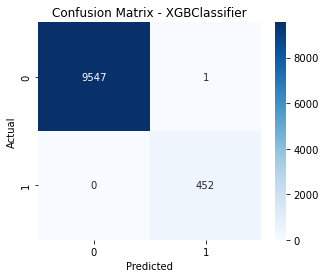

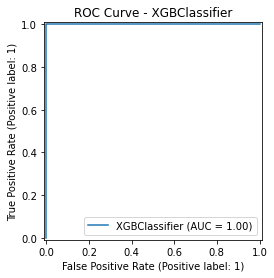

In [8]:
## 7. XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_params = {
    'n_estimators':[100,200],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.1,0.2],
    'subsample':[0.7,1]
}

xgb_grid = GridSearchCV(xgb, xgb_params, scoring='recall', cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print('Best Params:', xgb_grid.best_params_)
evaluate_model(xgb_grid.best_estimator_, X_test, y_test)


## 8. Feature Importance (using random Forest Example)

- Visualize top predictors for loan default


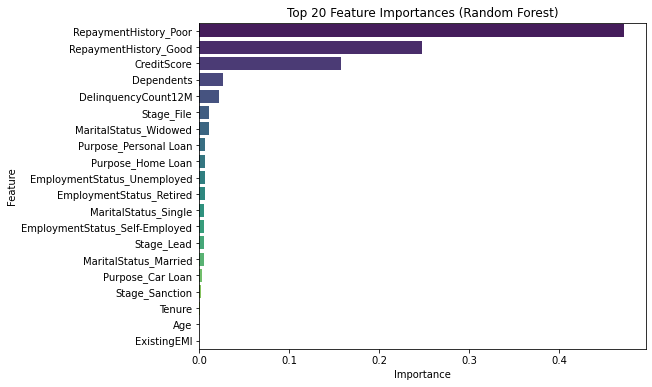

In [9]:
rf_model = rf_grid.best_estimator_
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## 9. Save Trained Models

- Save the best models for deployment
`

In [10]:
import joblib
os.makedirs('../deployment/model', exist_ok=True)

joblib.dump(lr_grid.best_estimator_, '../deployment/model/logistic_regression.pkl')
joblib.dump(dt_grid.best_estimator_, '../deployment/model/decision_tree.pkl')
joblib.dump(rf_grid.best_estimator_, '../deployment/model/random_forest.pkl')
joblib.dump(xgb_grid.best_estimator_, '../deployment/model/xgboost.pkl')

print('Models saved in deployment/model/')


Models saved in deployment/model/


## ✅ Summary

- Trained and tuned 4 ML algorithms on custom UAE synthetic loan dataset
- Used Recall as primary metric for detecting potential defaulters
- Saved models for deployment
- Top predictors: CreditScore, DelinquencyCount12M, ExistingEMI/Income ratio, RepaymentHistory, LoanAmount,
